# sklearn之分类算法与手写数字识别
>sklearn是Python的一个机器学习的库，它有比较完整的监督学习与非监督学习的模型。本文将使用sklearn库里的分类模型来对手写数字（MNIST）做分类实践。

* 数据介绍
* 数据读取与存储形式
* sklearn分类模型
* 代码实现与结果

# 1.数据介绍

>MNIST 数据集来自美国国家标准与技术研究所, National Institute of Standards and Technology (NIST). 训练集 (training set) 由来自 250 个不同人手写的数字构成, 其中 50% 是高中学生, 50% 来自人口普查局 (the Census Bureau) 的工作人员. 测试集(test set) 也是同样比例的手写数字数据.<br>
>MNIST 数据集可在 http://yann.lecun.com/exdb/mnist/ 获取, 它包含了四个部分:

* Training set images: train-images-idx3-ubyte.gz (9.9 MB, 解压后 47 MB, 包含 60,000 个样本)
* Training set labels: train-labels-idx1-ubyte.gz (29 KB, 解压后 60 KB, 包含 60,000 个标签)
* Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 解压后 7.8 MB, 包含 10,000 个样本)
* Test set labels: t10k-labels-idx1-ubyte.gz (5KB, 解压后 10 KB, 包含 10,000 个标签)

# 2.数据读取与存储形式
>将下载好的数据解压带代码目录下即可。
**此处直接挂在数据集**，数据文件时二进制格式的，所以要按字节读取。代码如下：

In [1]:
!unzip data/data7869/mnist.zip

Archive:  data/data7869/mnist.zip
   creating: mnist/
  inflating: mnist/t10k-images-idx3-ubyte.gz  
   creating: __MACOSX/
   creating: __MACOSX/mnist/
  inflating: __MACOSX/mnist/._t10k-images-idx3-ubyte.gz  
  inflating: mnist/train-images-idx3-ubyte.gz  
  inflating: __MACOSX/mnist/._train-images-idx3-ubyte.gz  
  inflating: mnist/train-labels-idx1-ubyte.gz  
  inflating: __MACOSX/mnist/._train-labels-idx1-ubyte.gz  
  inflating: mnist/t10k-labels-idx1-ubyte.gz  
  inflating: __MACOSX/mnist/._t10k-labels-idx1-ubyte.gz  


In [2]:
!gzip -dfq mnist/train-labels-idx1-ubyte.gz
!gzip -dfq mnist/t10k-labels-idx1-ubyte.gz
!gzip -dfq mnist/train-images-idx3-ubyte.gz
!gzip -dfq mnist/t10k-images-idx3-ubyte.gz

In [3]:
import struct,os
import numpy as np
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
import matplotlib.pyplot as plt

%matplotlib inline 

In [4]:
def load_mnist(image_file, label_file, path="mnist"):
    digits=np.arange(10)

    fname_image = os.path.join(path, image_file)
    fname_label = os.path.join(path, label_file)

    flbl = open(fname_label, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_image, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows*cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((1, rows*cols))
        labels[i] = lbl[ind[i]]

    return images, labels


train_image, train_label = load_mnist("train-images-idx3-ubyte", "train-labels-idx1-ubyte")
test_image, test_label = load_mnist("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte")

## 数据展示
>image和label都是数组，image内的每个元素为一个784维的向量，label内的每个元素为image同下标下元素表示的数字。<br>可以将读取到的灰度图通过matplotlib.pyplot展示出来：

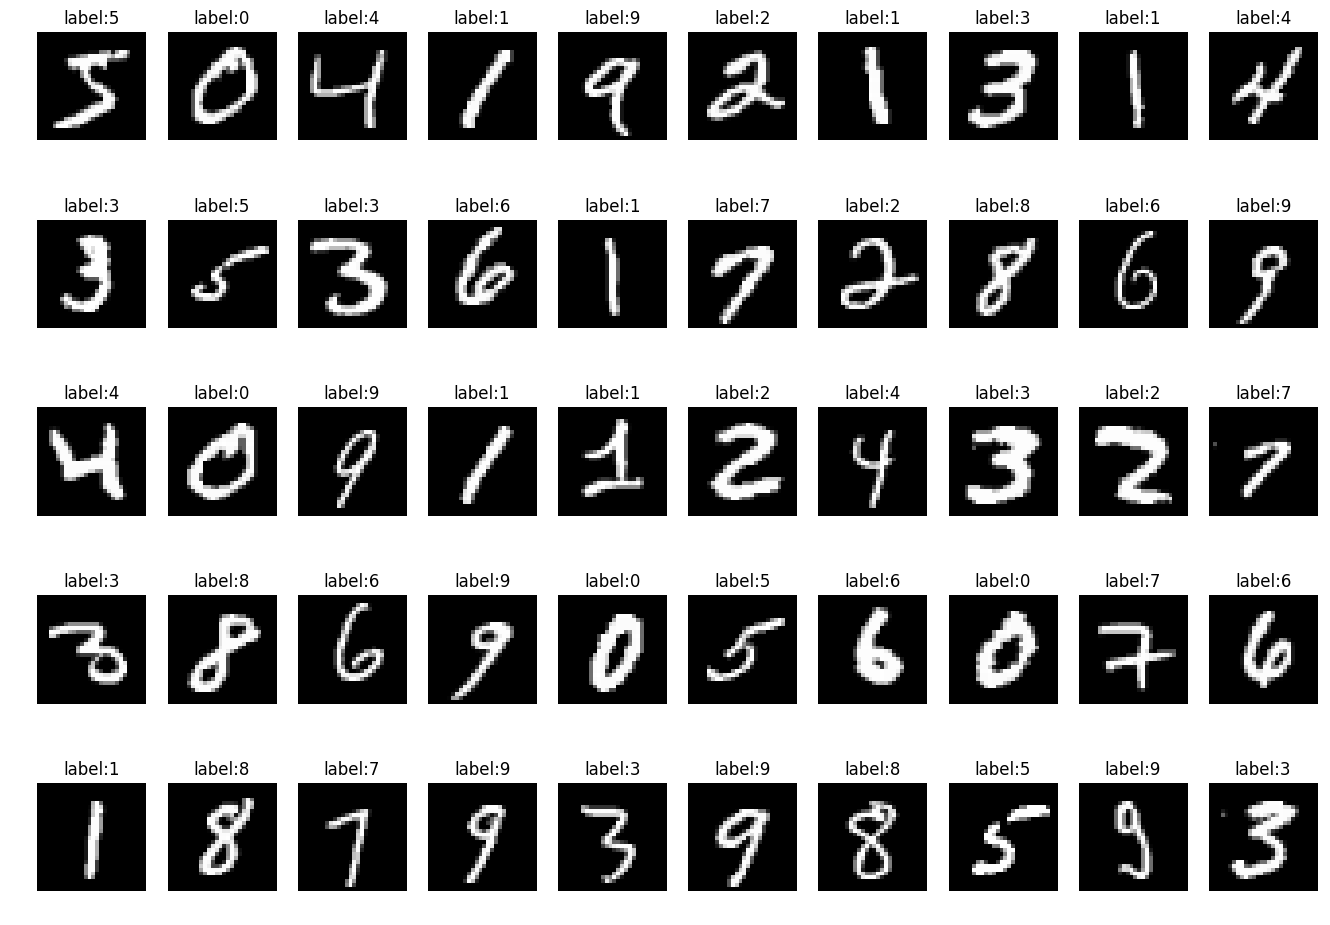

In [5]:
import matplotlib.pyplot as plt

def show_image(imgdata,imgtarget,show_column, show_row):
    #注意这里的show_column*show_row==len(imgdata)
    for index,(im,it) in enumerate(list(zip(imgdata,imgtarget))):
        xx = im.reshape(28,28)
        plt.subplots_adjust(left=1, bottom=None, right=3, top=2, wspace=None, hspace=None)
        plt.subplot(show_row, show_column, index+1)
        plt.axis('off')
        plt.imshow(xx , cmap='gray',interpolation='nearest')
        plt.title('label:%i' % it)
# 显示训练集前50数字
show_image(train_image[:50], train_label[:50], 10,5)

# 3.sklearn 分类模型
本文使用的sklearn分类模型有：
- K-Nearest Neighbor Classification
- Naive Bayes
- Decision Tree
- Random Forest
- Logistic Regression
- Support Vector Machine

>关于各分类模型在分类问题上的优缺点，推荐博文：

```
https://blog.csdn.net/u013909139/article/details/69740089
```

>关于Support Vector Machine原理的证明，推荐博文：

```
http://cuijiahua.com/blog/2017/11/ml_8_svm_1.html
http://cuijiahua.com/blog/2017/11/ml_9_svm_2.html
```

## 数据归一化
>现在我们已经有image数组和label数组了，那么我们能不能直接将数据套用sklearn的模型直接处理呢？答案是否定的。<br>
在做分类问题之前，数据的归一化处理也是十分必要的。而数据的归一化有两种常用方式：min-max标准化和Z-score标准化方法。推荐博文：<br>
```
https://blog.csdn.net/program_developer/article/details/78637711
````
此处采用min-max标准化将数据进行归一化操作。
`image = [im/255.0 for im in image]`



In [6]:
train_image=[im/255.0 for im in train_image]
test_image=[im/255.0 for im in test_image]

# 4.sklearn模型分类
>将数据进行归一化操作后，就可以使用sklearn的模型进行分类的实践了。 使用sklearn.metric对模型的分类结果进行评估：

## K-Nearest Neighbor Classification

In [7]:
print(len(train_image))
print(len(train_label))

60000
60000


In [8]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=10)
knc.fit(train_image,train_label.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
predict = knc.predict(test_image)
print("accuracy_score: %.4lf" % accuracy_score(predict,test_label))

In [ ]:
print("Classification report for classifier %s:\n%s\n" % (knc, classification_report(test_label, predict)))

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(train_image,train_label)
predict = mnb.predict(test_image)
print("accuracy_score: %.4lf" % accuracy_score(predict,test_label))
print("Classification report for classifier %s:\n%s\n" % (mnb, classification_report(test_label, predict)))


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(train_image,train_label)
predict = dtc.predict(test_image)
print("accuracy_score: %.4lf" % accuracy_score(predict,test_label))
print("Classification report for classifier %s:\n%s\n" % (dtc, classification_report(test_label, predict)))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(train_image,train_label)
predict = rfc.predict(test_image)
print("accuracy_score: %.4lf" % accuracy_score(predict,test_label))
print("Classification report for classifier %s:\n%s\n" % (rfc, classification_report(test_label, predict)))

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_image,train_label)
predict = lr.predict(test_image)
print("accuracy_score: %.4lf" % accuracy_score(predict,test_label))
print("Classification report for classifier %s:\n%s\n" % (lr, classification_report(test_label, predict)))

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(train_image,train_label)
predict = svc.predict(test_image)
print("accuracy_score: %.4lf" % accuracy_score(predict,test_label))
print("Classification report for classifier %s:\n%s\n" % (svc, classification_report(test_label, predict)))

各分类模型准确度比较：


<table><thead><tr><th>模型</th><th>准确度</th></tr></thead><tbody><tr><td>K-Nearest Neighbor Classification</td><td>0.9665</td></tr><tr><td>Naive Bayes</td><td>0.8375</td></tr><tr><td>Decision Tree</td><td>0.8758</td></tr><tr><td>Random Forest</td><td>0.9486</td></tr><tr><td>Logistic Regression</td><td>0.9202</td></tr><tr><td>Support Vector Machine</td><td>0.9769</td></tr></tbody></table>

>模型在使用的时候，参数的调整也是十分重要的。应该根据数据类型来进行调参和模型选择，才会有很好的拟合效果。但这不是这篇博客的主要目的，之后可以对参数进行研讨。

我们可以将预测结果展示出来：


In [ ]:
import matplotlib.pyplot as plt

def show_image(imgtestdata, imgtesttarget, show_column, show_row):
    #注意这里的show_column*show_row==len(imgtestdata)
    for index,(im,it) in enumerate(list(zip(imgtestdata, imgtesttarget))):
        xx = im.reshape(28,28)
        plt.subplots_adjust(left=1, bottom=None, right=3, top=4, wspace=None, hspace=None)
        plt.subplot(show_row, show_column, index+1)
        plt.axis('off')
        plt.imshow(xx , cmap='gray',interpolation='nearest')
        plt.title('predict:%i' % it)

In [ ]:
show_image(test_image[:100], predict, 10, 10)